# `datasets` and Remote URLs

Nowadays it's very usual to distribute large image datasets with links to the original images that were scraped, rather than the images themselves.

Consider, for example, [Conceptual Captions](https://huggingface.co/datasets/conceptual_captions). Each record contains an URL to the image and a text caption.

If we load it with `datasets`, images will not be downloaded.

In [1]:
from datasets import load_dataset

dataset = load_dataset("conceptual_captions")

No config specified, defaulting to: conceptual_captions/unlabeled
Found cached dataset conceptual_captions (/home/pedro/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8)


  0%|          | 0/2 [00:00<?, ?it/s]

`load_dataset` actually returns a dictionary with the dataset splits. Each split is a `Dataset` instance.

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_url', 'caption'],
        num_rows: 3318333
    })
    validation: Dataset({
        features: ['image_url', 'caption'],
        num_rows: 15840
    })
})

`Dataset`s are iterable and indexable.

In [3]:
valid = dataset["validation"]
valid[0]

{'image_url': 'https://i.pinimg.com/736x/66/01/6c/66016c3ba27c0e04f39e2bd81a934e3e--anita-ekberg-bob-hope.jpg',
 'caption': 'author : a life in photography -- in pictures'}

In [4]:
next(iter(valid))

{'image_url': 'https://i.pinimg.com/736x/66/01/6c/66016c3ba27c0e04f39e2bd81a934e3e--anita-ekberg-bob-hope.jpg',
 'caption': 'author : a life in photography -- in pictures'}

Let's create a simple function to retrieve image URLs.

In [5]:
import io
import requests
from PIL import Image

timeout = 2
def get_image_http(url):
    r = requests.get(url, timeout=2)
    if r.status_code == 200:
        r.raw.decode_content = True
        image = Image.open(io.BytesIO(r.content))
        return image

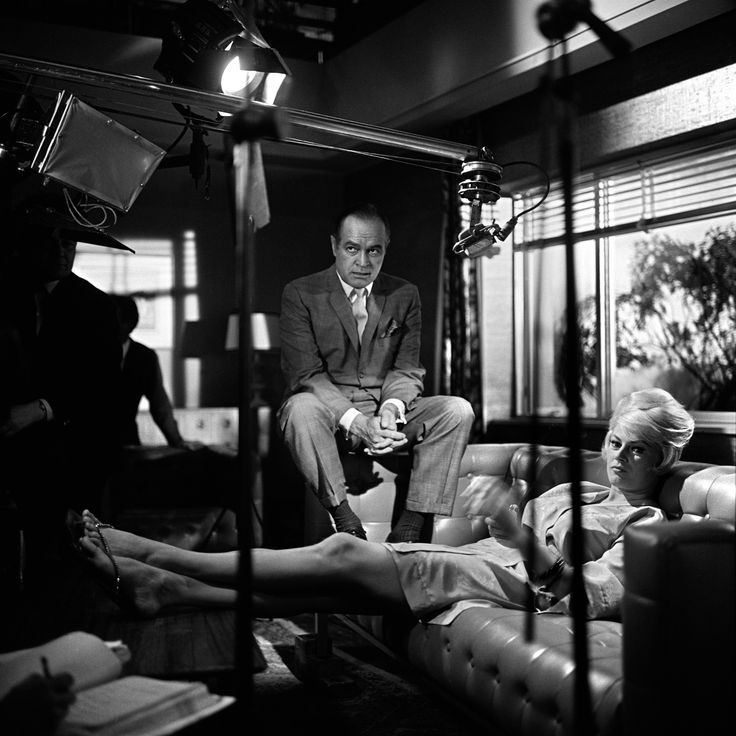

In [6]:
get_image_http(valid[0]["image_url"])

The `map` function can be used to apply transformations to a dataset. We could use it to process the dataset and download all the images.

**Note**: because the dataset was loaded in normal (non _streaming_) mode, this would process all the items and cache them locally as parquet files. This may be convenient if we have the disk space, but it could be impractical in some situations.

Let's verify by selecting a subset. The easiest way could be to do something like this:

In [7]:
# small_dataset = load_dataset("conceptual_captions", split="validation[:1%]")
small_dataset = load_dataset("conceptual_captions", split="validation[:20]")

No config specified, defaulting to: conceptual_captions/unlabeled
Found cached dataset conceptual_captions (/home/pedro/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8)


In [8]:
small_dataset

Dataset({
    features: ['image_url', 'caption'],
    num_rows: 20
})

We can't trust URLs from scraped datasets, they may be long gone. The processing function that we'll apply during mapping will do some very basic error handling.

In [9]:
def add_image(sample):
    try:
        return {"image": get_image_http(sample["image_url"])}
    except:
        return {"image": None}

In [10]:
small_dataset = small_dataset.map(add_image)

Loading cached processed dataset at /home/pedro/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8/cache-fe437448f3d39f72.arrow


This is iterative. If the process that the map function performs can be done on several samples at once, then we can use the `batched=True` argument and it'll receive a batch instead of a single sample.

In [11]:
small_dataset = small_dataset.filter(lambda x: x["image"] is not None)
small_dataset

Loading cached processed dataset at /home/pedro/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8/cache-6b4348a763894fee.arrow


Dataset({
    features: ['image_url', 'caption', 'image'],
    num_rows: 13
})

In [12]:
next(iter(small_dataset))

{'image_url': 'https://i.pinimg.com/736x/66/01/6c/66016c3ba27c0e04f39e2bd81a934e3e--anita-ekberg-bob-hope.jpg',
 'caption': 'author : a life in photography -- in pictures',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=736x736>}

## Streamed datasets

We'll now load the dataset in streaming mode. Just for fun, we'll use a version of the data with additional metadata fields. This is called a "configuration". It's exposed [in the hub](https://huggingface.co/datasets/conceptual_captions) with a dropdown list called `Subset`.

In [13]:
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

In [14]:
# Crop and tensorize

def center_crop(image, max_size=512):
    if image is None: return torch.tensor([0.])
    s = min(image.size)

    # Note: this would upscale too
    r = max_size / s
    s = (round(r * image.size[1]), round(r * image.size[0]))
    image = TF.resize(image, s, interpolation=InterpolationMode.LANCZOS)
    image = TF.center_crop(image, output_size=2 * [max_size])
    image = torch.unsqueeze(T.ToTensor()(image), 0)
    return image
    
def download_and_crop(url):
    try:
        image = get_image_http(url)
        if image is None: return None
        return center_crop(image)
    except:
        return None

def download_sample(sample):
    return {"image": download_and_crop(sample["image_url"])}

In [15]:
train_ds = load_dataset(
    "conceptual_captions", split="train", streaming=True, name="labeled"
)

In [16]:
train_ds = train_ds.filter(lambda x: x["confidence_scores"][0] > 0.98)
train_ds = train_ds.remove_columns(["labels", "MIDs", "confidence_scores"])
train_ds = train_ds.map(download_sample).filter(lambda x: x["image"] is not None)

The default format is "Python objects". We need to change it to prevent datasets from returning nested lists instead of tensors.

In [17]:
train_ds = train_ds.with_format("torch")

In [18]:
item = next(iter(train_ds))
item

{'image_url': 'https://thumb1.shutterstock.com/display_pic_with_logo/261388/223876810/stock-vector-christmas-tree-on-a-black-background-vector-223876810.jpg',
 'caption': 'christmas tree on a black background .',
 'image': tensor([[[[0.2549, 0.2549, 0.2510,  ..., 0.0000, 0.0000, 0.0000],
           [0.2510, 0.2510, 0.2510,  ..., 0.0000, 0.0000, 0.0000],
           [0.2471, 0.2471, 0.2471,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
      

In [19]:
item["image"].shape

torch.Size([1, 3, 512, 512])

**How does streaming actually work?**

See the implementation for this particular dataset in [`conceptual_captions.py` here](https://huggingface.co/datasets/conceptual_captions/tree/main)

### Parallel loading

As suggested in [the model card](https://huggingface.co/datasets/conceptual_captions), we can download the images using parallelization. This also works for streaming datasets, so we don't need to process the entire dataset beforehand.

We'll use batched mapping and a `ThreadPoolExecutor`.

In [20]:
from concurrent.futures import ThreadPoolExecutor

def fetch_images(batch, num_threads=20):
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image"] = list(executor.map(download_and_crop, batch["image_url"]))
    return batch

In [21]:
train_ds = load_dataset(
    "conceptual_captions", split="train", streaming=True, name="labeled"
)

In [22]:
download_bs = 16

In [23]:
train_ds = train_ds.filter(lambda x: x["confidence_scores"][0] > 0.98)
train_ds = train_ds.remove_columns(["labels", "MIDs", "confidence_scores"])
train_ds = train_ds.map(fetch_images, batched=True, batch_size=download_bs)
train_ds = train_ds.filter(lambda x: x["image"] is not None)
train_ds = train_ds.with_format("torch")

In [24]:
next(iter(train_ds))

{'image_url': 'https://thumb1.shutterstock.com/display_pic_with_logo/261388/223876810/stock-vector-christmas-tree-on-a-black-background-vector-223876810.jpg',
 'caption': 'christmas tree on a black background .',
 'image': tensor([[[[0.2549, 0.2549, 0.2510,  ..., 0.0000, 0.0000, 0.0000],
           [0.2510, 0.2510, 0.2510,  ..., 0.0000, 0.0000, 0.0000],
           [0.2471, 0.2471, 0.2471,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
      

### Create `DataLoader`

In [25]:
from torch.utils.data import DataLoader

In [33]:
train_ds = train_ds.shuffle(100)     # This should be larger

In [38]:
loader = DataLoader(train_ds, batch_size=4)
iter_loader = iter(loader)

In [39]:
%%time
batch = next(iter_loader)

CPU times: user 2min 24s, sys: 10.8 s, total: 2min 35s
Wall time: 3min 56s


In [40]:
%%time
batch = next(iter_loader)

CPU times: user 32.7 ms, sys: 0 ns, total: 32.7 ms
Wall time: 2.69 ms


In [41]:
batch["image"].shape

torch.Size([4, 1, 3, 512, 512])

We didn't need the unsqueeze after all.